In [1]:
%matplotlib inline
"""
data source:
https://zola.planning.nyc.gov/data#12.31/40.73327/-73.92447
https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
https://sfplanninggis.org/PIM/help.html
"""

import os
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime

from lib.utils import SamplePool, make_seed, make_circle_masks, get_rand_avail
from lib.utils import get_sobel, softmax
from lib.NCCAModel2 import NCCAModel2

In [2]:
with open('anchor_loc.pickle', 'rb') as handle:
    anchor_loc = pickle.load(handle)

root = "_maps/"
full_size = (100,100)
map_size = (80,80)
color_map = [(0.5,0.5,0.5),
             (0.5,1.0,0.5),
             (1.0,1.0,0.5),
             (1.0,0.7,0.2),
             (1.0,0.5,0.5),
             (1.0,0.5,1.0)]

################################################################

d_trains   = []
d_tests    = []
alive_maps = []

for d_i, obj_name in enumerate(list(anchor_loc.keys())[:10]):

    filenames = []
    common_index = {}

    for filename in os.listdir(root):
        if filename[:len(obj_name)]==obj_name:
            filenames.append(root+filename)

    for filename in filenames:
        with open(filename, 'rb') as handle:
            map_dict = pickle.load(handle)
        for index in map_dict:
            try:
                tmp = int(map_dict[index]['status'])
                if index in common_index:
                    common_index[index]+= 1
                else:
                    common_index[index] = 1
            except (TypeError, KeyError):
                continue

    common_index = [x for x in common_index.keys() if common_index[x]==len(filenames)]

    d_train = np.zeros([64, full_size[0], full_size[1], 4])
    d_test  = np.zeros([len(filenames)-d_train.shape[0], full_size[0], full_size[1], d_train.shape[-1]])

    for i,filename in enumerate(filenames[:d_train.shape[0]]):
        with open(filename, 'rb') as handle:
            map_dict = pickle.load(handle)
            for index in common_index:
                try:
                    status = min(int(map_dict[index]['status'])-1, 3)
                    d_train[i, index[0], index[1]] = np.zeros(d_train.shape[-1])
                    d_train[i, index[0], index[1], status] = 1
                except (TypeError, KeyError):
                    continue

    for i,filename in enumerate(filenames[d_train.shape[0]:]):
        with open(filename, 'rb') as handle:
            map_dict = pickle.load(handle)
            for index in common_index:
                try:
                    status = min(int(map_dict[index]['status'])-1, 3)
                    d_test[i, index[0], index[1]] = np.zeros(d_test.shape[-1])
                    d_test[i, index[0], index[1], status] = 1
                except (TypeError, KeyError):
                    continue

    alive_map = np.expand_dims(np.expand_dims(np.sum(d_train[0, ...], -1)>0.001, 0), -1)

    cut_off = ((full_size[0]-map_size[0])//2, (full_size[1]-map_size[1])//2)
    d_train = d_train[:, cut_off[0]:(cut_off[0]+map_size[0]),
                      cut_off[1]:(cut_off[1]+map_size[1]), :]
    d_test = d_test[:, cut_off[0]:(cut_off[0]+map_size[0]),
                    cut_off[1]:(cut_off[1]+map_size[1]), :]
    alive_map = alive_map[:, cut_off[0]:(cut_off[0]+map_size[0]),
                          cut_off[1]:(cut_off[1]+map_size[1]), :]

    print(d_train.shape, d_test.shape, alive_map.shape)
    
    d_trains.append(d_train)
    d_tests.append(d_test)
    alive_maps.append(alive_map)

(64, 80, 80, 4) (28, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (206, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (30, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (44, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (32, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (32, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (45, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (12, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (39, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (18, 80, 80, 4) (1, 80, 80, 1)


In [3]:
DEVICE = torch.device("cuda:0")
model_path = "models/ncca_softmax_multi_traffic.pth"

CHANNEL_N = 16
ALPHA_CHANNEL = 4

lr = 1e-3
lr_gamma = 0.99995
betas = (0.5, 0.5)
n_epoch = 100000

BATCH_SIZE = 10
N_STEPS = 128
POOL_SIZE = 256
CELL_FIRE_RATE = 0.5
CALIBRATION = 1.0
eps = 1e-3

USE_PATTERN_POOL = 1
DAMAGE_N = 3
TRANS_N = 3

In [4]:
valid_masks = []
for alive_map in alive_maps:
    valid_masks.append(alive_map.astype(bool))
valid_masks = np.concatenate(valid_masks, 0)

pools_list = []
for d_i, d_train in enumerate(d_trains):
    pools = []
    for _ in range(d_train.shape[0]):
        init_coord = get_rand_avail(valid_masks[d_i:(d_i+1)])
        seed = make_seed(map_size, CHANNEL_N, np.arange(CHANNEL_N-ALPHA_CHANNEL)+ALPHA_CHANNEL, init_coord)
        pools.append(SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0)))
    pools_list.append(pools)
    
my_model = NCCAModel2(CHANNEL_N, ALPHA_CHANNEL, CELL_FIRE_RATE, DEVICE).to(DEVICE)
my_model.load_state_dict(torch.load(model_path))
for param in my_model.parameters():
    param.requires_grad = False

In [16]:
def test(x, target, valid_mask_t, calibration_map, steps):
    history = [x.detach().cpu().numpy(),]
    for _ in range(steps):
        x = my_model(x, valid_mask_t, 1)
        h = torch.softmax(x[..., :ALPHA_CHANNEL], -1)
        t = target[..., :ALPHA_CHANNEL]
        _delta = t*(h-1)
        delta = _delta * calibration_map * CALIBRATION
        y1 = x[..., :ALPHA_CHANNEL]-delta
        
        alpha_h = x[..., ALPHA_CHANNEL:(ALPHA_CHANNEL+1)]
        y2 = alpha_h - 2 * (alpha_h-valid_mask_t) * calibration_map * CALIBRATION
        x = torch.cat((y1,y2,x[..., (ALPHA_CHANNEL+1):]), -1)
        history.append(x.detach().cpu().numpy())
    return x, history
    
# 重新选择target
calibration_map = make_circle_masks(BATCH_SIZE, map_size[0], map_size[1], rmin=0.5, rmax=0.5)[..., None]
calibration_map = torch.from_numpy(calibration_map.astype(np.float32)).to(DEVICE)

targets = []
# pre_target_i = [-1]*10
pre_target_i = [1, 122, 7, 6, 19, 27, 19, 11, 22, 6]
target_is = []
for d_i in range(10):
    if pre_target_i[d_i]<0:
        target_i = np.random.randint(d_tests[d_i].shape[0])
    else:
        target_i = pre_target_i[d_i]
    print(target_i)
    target_is.append((d_i, target_i))
    target = np.concatenate((d_tests[d_i][target_i:target_i+1], valid_masks[d_i:(d_i+1)]), -1)
    targets.append(target)
targets = np.concatenate(targets, 0).astype(np.float32)
targets[..., :-1] += eps
targets[..., :-1] /= np.sum(targets[..., :-1], axis=-1, keepdims=True)
_target = torch.from_numpy(targets).to(DEVICE)

x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)*0
x0 = torch.from_numpy(x0.astype(np.float32)).to(DEVICE)

valid_mask_t = valid_masks[[tmp[0] for tmp in target_is]]
valid_mask_t = torch.from_numpy(valid_mask_t.astype(np.float32)).to(DEVICE)

x, history = test(x0, _target, valid_mask_t, calibration_map, N_STEPS)
# x.backward()
history = np.array(history)
cali_map_numpy = calibration_map.detach().cpu().numpy()
print("history generated", history.shape)

1
122
7
6
19
27
19
11
22
6
history generated (129, 10, 80, 80, 16)


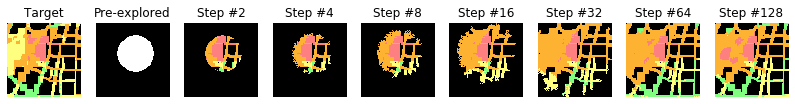

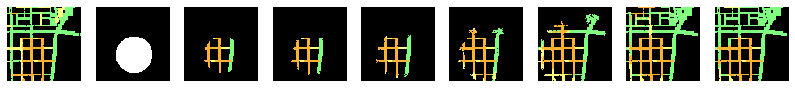

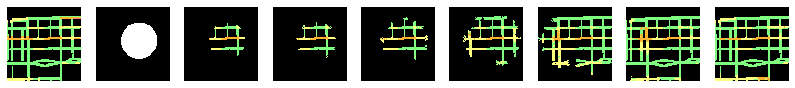

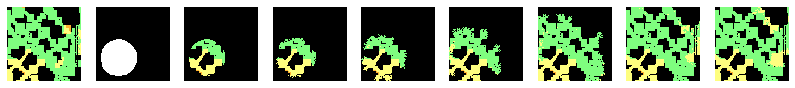

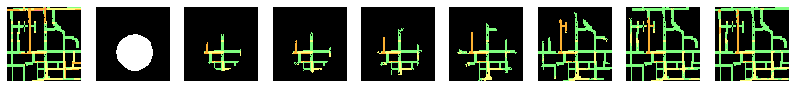

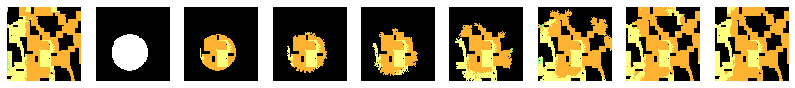

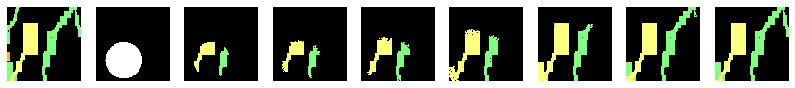

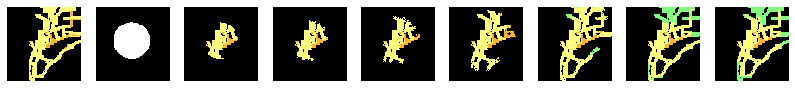

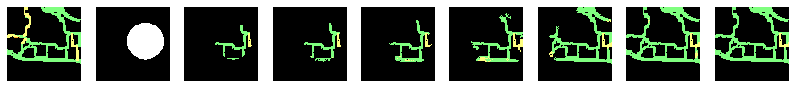

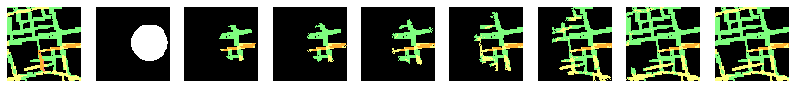

In [17]:
color_map = [(0.0,0.0,0.0),
             (0.5,1.0,0.5),
             (1.0,1.0,0.5),
             (1.0,0.7,0.2),
             (1.0,0.5,0.5)]

for history_i in range(10):
    history_t = history[:,history_i,...,:(ALPHA_CHANNEL+1)]
    targets_t = targets[history_i,...]

    map_dict = np.argmax(targets_t[..., :-1], -1)
    _map = np.zeros([map_dict.shape[0], map_dict.shape[1], 3])
    for i in range(_map.shape[0]):
        for j in range(_map.shape[1]):
            if targets_t[i,j,-1]>0.1:
                _map[i,j] = color_map[map_dict[i,j]+1]

    plt.figure(figsize=(14,6))
    plt.subplot(1,9,1)
    rotated_img = ndimage.rotate(_map*0.999+0.00001, 90)
    plt.imshow(rotated_img)
    if history_i==0: plt.gca().set_title("Target")
    plt.axis('off')
    plt.subplot(1,9,2)
    rotated_img = ndimage.rotate(cali_map_numpy[history_i, ..., 0], 90)
    plt.imshow(rotated_img, cmap=plt.cm.gray, vmin=0, vmax=1)
    if history_i==0: plt.gca().set_title("Pre-explored")
    plt.axis('off')
    
    shown_steps = [2,4,8,16,32,64,128]
    for index, i_map in enumerate(shown_steps):
        plt.subplot(1,9,index+3)
        i_map-=1

        map_dict = np.argmax(history_t[i_map, ..., :-1], -1)
        _map = np.zeros([map_dict.shape[0], map_dict.shape[1], 3])
        for i in range(_map.shape[0]):
            for j in range(_map.shape[1]):
                if history_t[i_map,i,j,-1]>0.1:
                    _map[i,j] = color_map[map_dict[i,j]+1]

        rotated_img = ndimage.rotate(_map*0.999+0.00001, 90)
        plt.imshow(rotated_img)
        if history_i==0: plt.gca().set_title('Step #'+str(i_map+1))
        plt.axis('off')
    plt.show()

In [21]:
percentages = []
for _ in range(10):
    for d_i in range(10):
        targets = []
        target_is = []
        for target_i in range(d_tests[d_i].shape[0]):
            target_is.append((d_i, target_i))
            target = np.concatenate((d_tests[d_i][target_i:target_i+1], valid_masks[d_i:(d_i+1)]), -1)
            targets.append(target)
        targets = np.concatenate(targets, 0).astype(np.float32)
        _target = torch.from_numpy(targets).to(DEVICE)
        
        calibration_map = make_circle_masks(_target.size(0), map_size[0], map_size[1],
                                            rmin=0.5, rmax=0.5)[..., None]
        calibration_map = torch.from_numpy(calibration_map.astype(np.float32)).to(DEVICE)
        x0 = np.repeat(seed[None, ...], _target.size(0), 0)*0
        x0 = torch.from_numpy(x0.astype(np.float32)).to(DEVICE)

        valid_mask_t = valid_masks[[tmp[0] for tmp in target_is]]
        valid_mask_t = torch.from_numpy(valid_mask_t.astype(np.float32)).to(DEVICE)

        x, history = test(x0, _target, valid_mask_t, calibration_map, N_STEPS)
        
        hyp = x.detach().cpu().numpy()
        hyp = np.argmax(hyp[..., :(ALPHA_CHANNEL+1)], -1)
        y = np.argmax(targets, -1)
        percentage = np.sum((hyp==y)*alive_maps[d_i][...,0])/(np.sum(alive_maps[d_i])*hyp.shape[0])
        percentages.append(percentage)
        print(percentage)
print("---------")
print(np.mean(percentages))

0.6557621502209131
0.7531524208975867
0.7594786015672091
0.7239869964007895
0.6608549288617886
0.803313364624506
0.7698341994555803
0.8309084126095878
0.8490995998221432
0.8345033486645687
0.637711708394698
0.7593831673297827
0.7592224231464738
0.7202542668059909
0.6776549796747967
0.7906913908102767
0.7610987379361545
0.8126748740906548
0.8429116644434563
0.8495521665456306
0.6487297496318115
0.7521038592457541
0.7658981314044605
0.7331185417392314
0.6732405995934959
0.7840059906126482
0.7914625092798813
0.8107162842753217
0.8525270490588409
0.8260308238521746
0.6477724594992637
0.7522655218558868
0.757157926461724
0.7086845466155811
0.6781631097560976
0.8037302371541502
0.7849913387775304
0.8409811602313001
0.8408366681488069
0.8326474622770919
0.6371686303387334
0.7546500453553434
0.776130198915009
0.7314582607686057
0.667603531504065
0.7841681077075099
0.7678173719376392
0.8002704719268793
0.8513598636431007
0.8260509965302993
0.6548969072164949
0.746346874073808
0.7728149487643159

In [22]:
percentages = []
for _ in range(10):
    for d_i in range(10):
        targets = []
        target_is = []
        for target_i in range(d_trains[d_i].shape[0]):
            target_is.append((d_i, target_i))
            target = np.concatenate((d_trains[d_i][target_i:target_i+1], valid_masks[d_i:(d_i+1)]), -1)
            targets.append(target)
        targets = np.concatenate(targets, 0).astype(np.float32)
        _target = torch.from_numpy(targets).to(DEVICE)
        
        calibration_map = make_circle_masks(_target.size(0), map_size[0], map_size[1],
                                            rmin=0.5, rmax=0.5)[..., None]
        calibration_map = torch.from_numpy(calibration_map.astype(np.float32)).to(DEVICE)

        x0 = np.repeat(seed[None, ...], _target.size(0), 0)*0
        x0 = torch.from_numpy(x0.astype(np.float32)).to(DEVICE)

        valid_mask_t = valid_masks[[tmp[0] for tmp in target_is]]
        valid_mask_t = torch.from_numpy(valid_mask_t.astype(np.float32)).to(DEVICE)

        x, history = test(x0, _target, valid_mask_t, calibration_map, N_STEPS)
        
        hyp = x.detach().cpu().numpy()
        hyp = np.argmax(hyp[..., :6], -1)
        y = np.argmax(targets, -1)
        percentage = np.sum((hyp==y)*alive_maps[d_i][...,0])/(np.sum(alive_maps[d_i])*hyp.shape[0])
        percentages.append(percentage)
        print(percentage)
print("---------")
print(np.mean(percentages))

0.6239449097938145
0.7395206984273821
0.7449635510849909
0.6936981162196679
0.6618711890243902
0.7784322504940712
0.705517469376392
0.7859103945159485
0.8766821712427746
0.7884837962962963
0.6338635631443299
0.7393472479185939
0.7378503616636528
0.6970266602809706
0.6633161839430894
0.7776718441205533
0.71118109688196
0.7701804700615557
0.8788046423410405
0.7903560729847494
0.62277706185567
0.7383137719703978
0.7385637997287523
0.6968590357598978
0.6614662728658537
0.7817788105237155
0.7356973830734966
0.7790203553441523
0.8808819544797688
0.7855108478576616
0.6176183956185567
0.7480559088806661
0.7359643422242315
0.70242656449553
0.6624587144308943
0.7794396924407114
0.7270409938752784
0.7764234750979295
0.8741306900289018
0.7857888525780683
0.6394249355670103
0.7480197733580018
0.7491735420433996
0.6860791826309067
0.6590447154471545
0.7800997406126482
0.7274063891982183
0.7749720201454953
0.880915823699422
0.7866455610021786
0.6187822164948453
0.739751965772433
0.7371581148282098
0.

## Speed Test

In [23]:
times = []
valid_mask_t = torch.from_numpy(np.ones([1,80,80,1]).astype(np.float32)).to(DEVICE)
for d_i in range(10):
    _target = torch.from_numpy(d_trains[d_i].astype(np.float32)).to(DEVICE)

    calibration_map = make_circle_masks(_target.size(0), map_size[0], map_size[1],
                                        rmin=0.5, rmax=0.5)[..., None]
    calibration_map = torch.from_numpy(calibration_map.astype(np.float32)).to(DEVICE)

    x0 = np.repeat(seed[None, ...], _target.size(0), 0)*0
    x0 = torch.from_numpy(x0.astype(np.float32)).to(DEVICE)

    start_time = time.time()
    x, history = test(x0, _target, valid_mask_t, calibration_map, N_STEPS)
    times.append((time.time()-start_time)/_target.size(0))
    print(times[-1])
print("---------")
print(np.mean(times))

0.03891327977180481
0.04005876183509827
0.04132132604718208
0.04402513429522514
0.04346586391329765
0.04147135838866234
0.03921307995915413
0.038483794778585434
0.04098214581608772
0.044003926217556
---------
0.04119386710226536
